# What is the astropy.modeling package and why is it useful?
<div style="background-color:#FCF3CF; text-align:left; vertical-align:middle; padding:10px; margin-top:10px">

astropy.modeling provies a framework for representing models, performing model evaluation, and fitting models to data.
<br>
<ul>
<li> Models do not reference fitting algorithms explicitly, this means that different fitting algorithms can be used without updating the model itself.
<li> Models can be chained together to represent transforms that are dependent on each other, or follow each other in an explicit order.
</ul>
</div>



## Overview of core astropy.modeling features

- <i><strong>simple models</strong></i>: one and two dimensional models 
- <i><strong>fitters</strong></i>: combine optimization algorithms with statistic functions to perform fitting 
- <i><strong>combined models</strong></i>: new models or classes that are the combination of instances, classes or result from composition
- <i><strong>creating new models</strong></i>: defining a new model using a custom decorator or subclass


In [1]:
# make sure plots show up inside the notebook 
%matplotlib inline
from matplotlib import pyplot as plt

# import other useful libraries
import numpy as np

## Example Real World Use-Cases 
The following real world examples will be discussed throughout this notebook as we look at some of the capabilities of the modeling. and fitting packages
* adding two gaussians together to create a spectral line
* fitting an image of a galaxy for a model including a disk with rotation
* creating a transform chain that moves one set of values to another


### <font color="blue">Adding two gaussians together to create a spectral line

In [2]:
# a number of predefined models exist under the modeling namespace "models"
from astropy.modeling import models

<strong>Most models are defined with their parameters and they maintain an ordered list of parameter names.</strong>
<br>The names of the parameters can be easily found by asking the model itself:

In [3]:
models.Gaussian1D.param_names

('amplitude', 'mean', 'stddev')

<strong>Now we know we can specify the amplitude, mean, and standard deviation for the Gaussian1D model.</strong><br>
The order of the Model.param_names list is important because models can be initialized by simply providing the values as positional arguments.
<br>Let's create our first model:

In [4]:
gaussian_1 = models.Gaussian1D(amplitude=2.5, mean=0.9, stddev=0.5)

<strong>Models have also a *parameters* attribute which is a flattened list of all parameter values.</strong>
<br>It is what fitters operate on and can be used to update a model's parameters. 
<br>The values are in the same order as *Model.param_list*.

In [5]:
gaussian_1.parameters

array([2.5, 0.9, 0.5])

<strong> It's possible to set the model parameter values from the model object itself. </strong>
<br>Below, I'll create another gaussian, but have it initialized with the default parameter values for the model.
<br>Most models have default values for their parameters and can be initialized without providing initial values.

In [6]:
gaussian_2 = models.Gaussian1D()
print(gaussian_2)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    amplitude mean stddev
    --------- ---- ------
          1.0  0.0    1.0


<strong>I can re-set the model parameters by assigning their values directly:

In [7]:
gaussian_2.amplitude = 1.6
gaussian_2.mean = 1.8
gaussian_2.stddev = 0.1
print(gaussian_2)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    amplitude mean stddev
    --------- ---- ------
          1.6  1.8    0.1


<strong>Models are evaluated like functions, by passing the inputs. Each dimension is a separate input.</strong>
<br>Below, we'll generate some gaussian data with some added noise to make it a little more realistic.


In [8]:
np.random.seed(0)
data1 = np.linspace(-5., 5., 200)
noise = np.random.normal(0., 0.2, data1.shape)

# now, feed the data to the models and add noise
g1 = gaussian_1(data1) + noise
g2 = gaussian_2(data1) + noise

<strong>You can see on the plot that we have two different gaussians, we are going to add them together to make a slightly more complex structure.

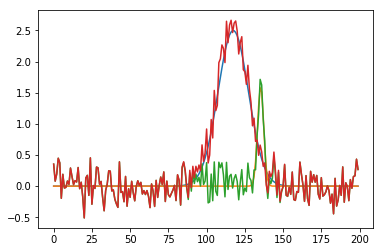

In [9]:
plt.plot(gaussian_1(data1))
plt.plot(gaussian_2(data1))
plt.plot(g2)
plt.plot(g1)

<strong> Models also support names. <br>
We didn't assign a name to either of the gaussians we are working with here, but we can now:

In [10]:
print(gaussian_1.name)

None


In [11]:
gaussian_1.name = "main gaussian"
gaussian_2.name = "line gaussian"

<strong>astropy.modeling supports model combination using arithmetic operators and the specially defined **join (&)** and **composition ( | )** operators. <br> Here we'll simply add the two models we created to generate the compound model:

In [12]:
combined_gaussians = gaussian_1 + gaussian_2

<strong>You can see that the names we applied to the individual models are carried through:

In [13]:
combined_gaussians.submodel_names

('main gaussian', 'line gaussian')

Text(0.5, 1.0, 'Two-Gaussian Model')

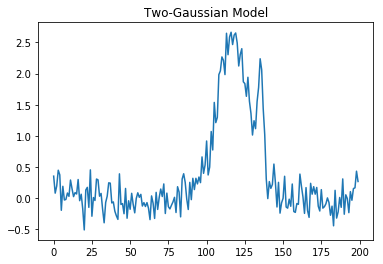

In [14]:
# Evaluate the combined model with the dataset
combined_data = combined_gaussians(data1) + noise
plt.plot(combined_data)
plt.title('Two-Gaussian Model')

<strong>The compound combined_gaussians model provides the same result as the individual model results. </strong>

Text(0.5, 1.0, 'Models evaluated separately')

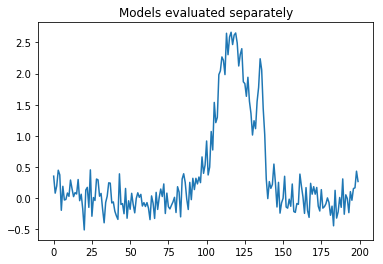

In [15]:
separate_data = gaussian_1(data1) + gaussian_2(data1) + noise
plt.plot(separate_data)
plt.title("Models evaluated separately")

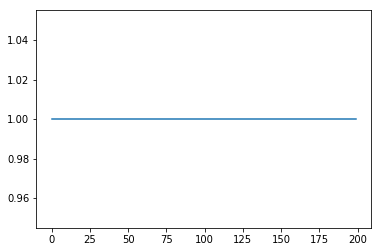

In [16]:
# For good measure, lets demonstrate the equivalence 
plt.plot( combined_data / separate_data)

<strong>Models can be introspected to find out more about their inputs and outputs.<strong>

In [17]:
print("combined_gaussians.n_inputs:", combined_gaussians.n_inputs)
print("combined_gaussians.n_outputs:", combined_gaussians.n_outputs)

combined_gaussians.n_inputs: 1
combined_gaussians.n_outputs: 1


<strong>and you can always look at the raw summary of their contents:

In [18]:
print(combined_gaussians)

Model: CompoundModel0
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=2.5, mean=0.9, stddev=0.5, name='main gaussian')>

    [1]: <Gaussian1D(amplitude=1.6, mean=1.8, stddev=0.1, name='line gaussian')>
Parameters:
    amplitude_0 mean_0 stddev_0 amplitude_1 mean_1 stddev_1
    ----------- ------ -------- ----------- ------ --------
            2.5    0.9      0.5         1.6    1.8      0.1


## Fitters : combine optimization algorithms with statistic functions to perform fitting.</strong>

<strong>Fitters are under a common namespace too.</strong>

In [19]:
from astropy.modeling import fitting

<strong>We'll apply a fitter to the noisy gaussian_1 data we created above:

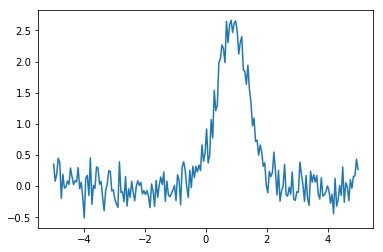

In [20]:
# Remember what the data looks like
plt.plot(data1, g1)

<strong>Create a fitter which uses the Levenberg-Marquardt optimization algorithm and least squares statistics.</strong>

When you pass the model and the data to the fitter, the output is a new model with fitted parameters.


In [21]:
fitter = fitting.LevMarLSQFitter()

# use the default gaussian model as input to the fitter
gauss_model = models.Gaussian1D()
model = fitter(gauss_model, data1, g1)

In [22]:
print("Fitted Model parameters: {}\nOriginal Gaussian parameters: {}".format(model.parameters, gaussian_1.parameters))

Fitted Model parameters: [2.59137205 0.88344118 0.50753749]
Original Gaussian parameters: [2.5 0.9 0.5]


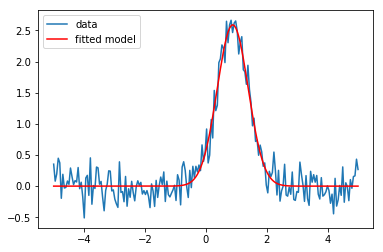

In [23]:
plt.plot(data1, g1, label='data')
plt.plot(data1, model(data1), 'r', label='fitted model')
plt.legend(loc=2)

<strong>Fitters support parameter constraints. </strong>
<br>They can be of types *fixed*, *tied* and *bounds*.



In [24]:
gauss_model.parameter_constraints

('fixed', 'tied', 'bounds', 'prior', 'posterior')

<strong>Fixed parameter constraints are boolean attributes. Let's fix the amplitude to its original value:</strong>

In [25]:
gauss_model.amplitude = 2
gauss_model.amplitude.fixed = True
model = fitter(gauss_model, data1, g1)
print(model.parameters)

[2.         0.88226824 0.59914998]


<strong> This is what the model looks like with the fixed-amplitude constraint:</strong>

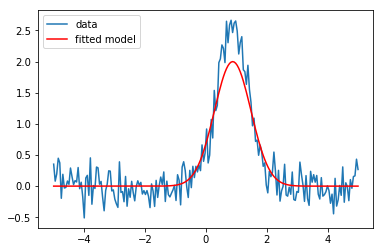

In [26]:
plt.plot(data1, g1, label='data')
plt.plot(data1, model(data1), 'r', label='fitted model')
plt.legend(loc=2)

<strong>Bounds can be set on a parameter, and used during fitting, either by using *min* and *max* or the *bounds* attribute.<br>
<em>Different fitters support different types of contstraints.<em>

In [27]:
print(fitter)
fitter.supported_constraints

['fixed', 'tied', 'bounds']

In [28]:
gauss_model.stddev.min = .1
gauss_model.stddev.max = .2
print(gauss_model.stddev.bounds)

(0.1, 0.2)


<strong>Compound models also support parameter constraints. There, constraints are defined on parameters of the compound model, not parameters of the submodels.

<strong> What happens with the bounds we added to the model stddev and the fixed amplitude constraint?</strong>

In [29]:
model = fitter(gauss_model, data1, g1)
print(model.parameters)

[2.         0.82217415 0.2       ]


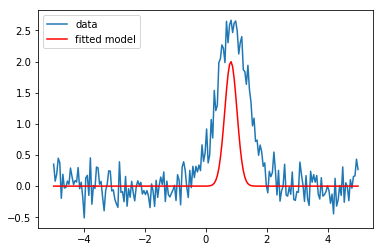

In [30]:
plt.plot(data1, g1, label='data')
plt.plot(data1, model(data1), 'r', label='fitted model')
plt.legend(loc=2)

<strong>It's also possible to tie (or link) two parameters.<br>
In the next example the stddev parameter is tied to the amplitude using a function reference.

In [31]:
def tie_stddev_ampl(model):
    return model.amplitude / 3.78

# set the parameter directly using the reference to the function
gauss_model.stddev.tied = tie_stddev_ampl

# set the stddev max back to a more reasonable value for this and unfix the amplitude
gauss_model.stddev.max = 0.8
gauss_model.amplitude.fixed = False

[2.28520094 0.87976985 0.60455051]


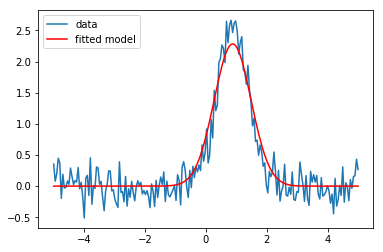

In [32]:
model_tied = fitter(gauss_model, data1, g1)
print(model_tied.parameters)
plt.plot(data1, g1, label='data')
plt.plot(data1, model_tied(data1), 'r', label='fitted model')
plt.legend(loc=2)

<strong>astropy.modeling has several other fitters: *SimplexLSQFitter*, *SLSQPLSQFitter* and *LinearLSQFitter*.

*LinearLSQFitter* can be used only with linear models and provides an exact solution.

### Example: Let's look at a different model 

Create a Chebyshev model, evaluate it and add noise to the data.

In [33]:
models.Chebyshev1D?

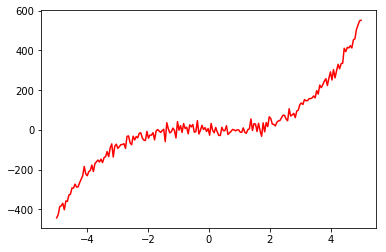

In [34]:
cheb1 = models.Chebyshev1D(degree=3, c0=1, c2=1, c3=1)
cdata = cheb1(data1) + np.random.normal(0, 20, data1.shape)
plt.plot(data1, cdata, 'r')

<strong>Fit a *Chebyshev1D* polynomial using the *LinearLSQFitter*.</strong>

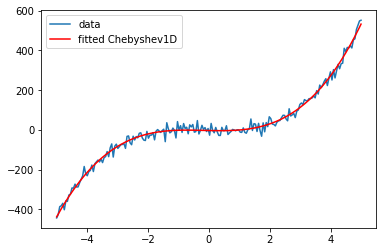

In [35]:
linfitter = fitting.LinearLSQFitter()
model = linfitter(cheb1, data1, cdata)

plt.plot(data1, cdata, label='data')
plt.plot(data1, model(data1), 'r', label='fitted Chebyshev1D')
plt.legend(loc=2)

## Exercise 1:

#Generate fake data
```
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)
```
- Fit the data with a Trapezoid1D model.
- Fit a Gaussian1D model to it.
- Display the results.

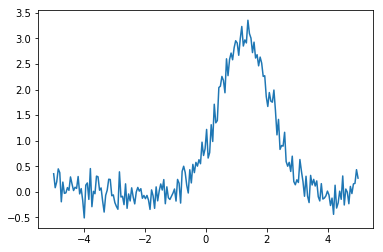

In [36]:
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)
plt.plot(x,y)

Model: Trapezoid1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            x_0               width               slope       
    ----------------- ------------------ ------------------ -------------------
    2.618580760201182 1.3273812492221355 1.5245561470225297 -0.3691951502976807


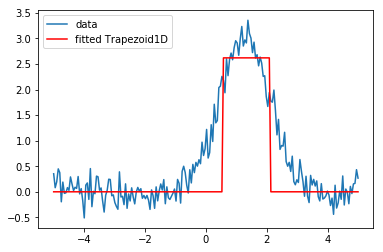

In [37]:
# Fit the data with a Trapezoid1D model
fitter = fitting.LevMarLSQFitter()  # Not really necessary to re-define this, but put it here for completeness.
trap_model = models.Trapezoid1D()
model = fitter(trap_model, x, y)
print(model)

plt.plot(x,y, label='data')
plt.plot(x, model(x), 'r', label='fitted Trapezoid1D')
plt.legend(loc=2)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev      
    ------------------ ------------------ ------------------
    3.0470524687449143 1.2743014580861238 0.8135350264067557


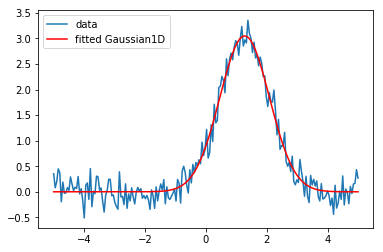

In [38]:
# Fit a Gaussian1D model to it.
gauss_model = models.Gaussian1D()
model = fitter(gauss_model, x, y)
print(model)

plt.plot(x,y, label='data')
plt.plot(x, model(x), 'r', label='fitted Gaussian1D')
plt.legend(loc=2)

### <font color="blue">Fitting an image of a disk galaxy with a model</font>

<strong>First we'll create an example dataset:

In [39]:
# Generate a noisy background
np.random.seed(0)
sky = np.random.normal(loc=0., scale=2, size=(128, 128))

# Generate a fuzzy galaxy disk
x, y = np.mgrid[:128, :128]
gal_model = models.Gaussian2D(amplitude=0.0008, x_mean=60, y_mean=60, x_stddev=25, y_stddev=5, theta=0.5)
galaxy = gal_model(x, y) * 50000.

# combine the background and galaxy to create the image of the fake scene
image = galaxy + sky


<strong>Let's take a look at the galaxy stamp that we created:</strong>

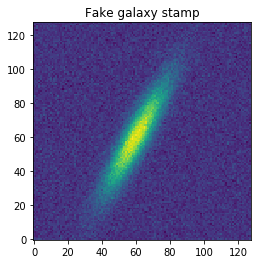

In [40]:
plt.title("Fake galaxy stamp")
plt.imshow(image, origin='lower')

<strong>Now, let's work backwards and try and fit this galaxy with a model.</strong>

In [41]:
# We'll use the Levenberg-Marquardt optimization algorithm and least squares statistics.
fitter = fitting.LevMarLSQFitter()

<strong>We'll assume the background follows a 2D Const and set the value to the median of the image.

In [42]:
sky_model = models.Const2D()
sky_model.amplitude = np.median(image.flatten())
sky_model.amplitude.fixed = True

<strong>We'll assume the galaxy follows a 2D Gaussian model, and add initial parameters that act as our starting guess.</strong>
<br>REM our input model parameters were:  models.Gaussian2D(0.0008, 60, 60, 25, 5, 0.5)

In [43]:
galaxy_model = models.Gaussian2D(amplitude=0.,x_mean=55, y_mean=55, x_stddev=20, y_stddev=8, theta=0.)
galaxy_model.theta.min = 0
galaxy_model.theta.max = 2. * np.pi

<strong>Create the compound model that will represent the model of our scene:

In [44]:
scene = sky_model + galaxy_model

<strong>Now use the fitter to fit the image to the scene model:

In [45]:
model = fitter(scene , x, y, image)

In [46]:
print(model)

Model: CompoundModel1
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const2D(amplitude=0.45603116)>

    [1]: <Gaussian2D(amplitude=0., x_mean=55., y_mean=55., x_stddev=20., y_stddev=8., theta=0.)>
Parameters:
       amplitude_0        amplitude_1    ...     y_stddev_1          theta_1      
    ------------------ ----------------- ... ----------------- -------------------
    0.4560311643144226 40.03481795035265 ... 4.897920893974365 0.49913621368169087


<strong> Let's visually see how we did by plotting up the results: </strong>

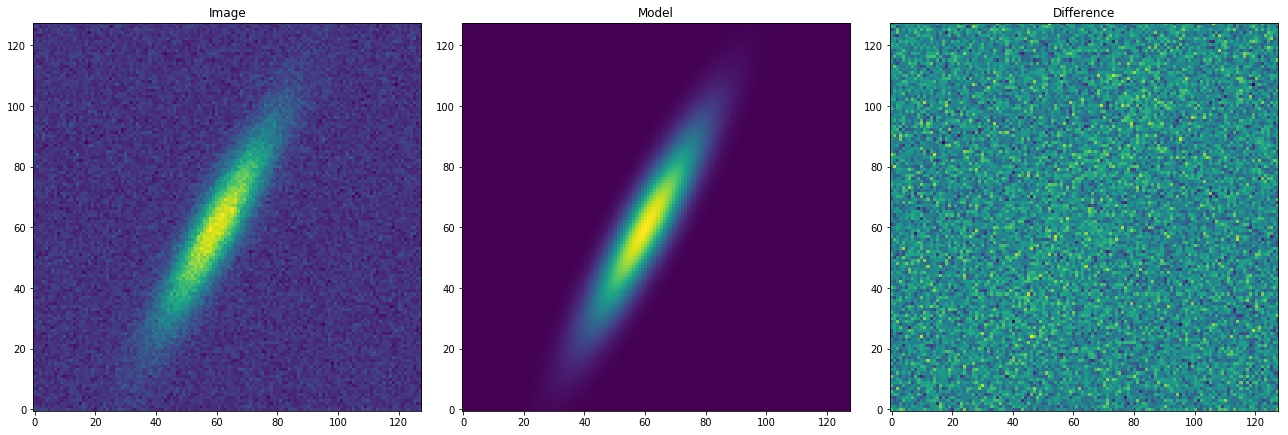

In [47]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,18))
ax1.set_title('Image')
ax1.imshow(image, origin='lower')
ax2.set_title('Model')
ax2.imshow(model(x,y), origin='lower')
ax3.set_title('Difference')
ax3.imshow(image - model(x,y), origin='lower')
plt.tight_layout()

## Model Sets

<strong>There are cases when it's useful to describe many models of the same type but with different parameter values.</strong>
<ul><li>This could be done by passing *n_models* to the model with an integer value indicating the number of models.
<li>It is especially useful in the context of simultaneously fitting many linear models using the *LinearLSQFittter*.
</ul>
<strong><em>Evaluation of sets of models works for all models while fitting of sets of models is currently supported only for linear models.</em></strong>

In [48]:
# This defines one model
poly = models.Polynomial1D(degree=2, c0=0.5, c1=0, c2=1)
print(poly)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
     c0  c1  c2
    --- --- ---
    0.5 0.0 1.0


<strong> Lets make a set of 10 models</strong>
<br>Here we'll send in an array of values for each of the coefficients, leaving c1 as it's default

In [49]:
poly10 = models.Polynomial1D(degree=2,
                             c0=0.5*np.ones(10) * np.random.normal(0, .1, 10),
                             c2=np.ones(10) * np.random.normal(1, .1, 10),
                             n_models=10)
print(poly10)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 10
Degree: 2
Parameters:
              c0            c1         c2        
    ---------------------- --- ------------------
      0.011246531607976177 0.0 0.9907032675216323
       0.01404642547068686 0.0 0.9853521112690634
      -0.04665250328866323 0.0 1.0605427132265335
      0.022739182797274764 0.0 0.9641547033430489
       0.02712452507931273 0.0 1.1156211248705825
    0.00020917928743619847 0.0 1.0319077495286164
       0.04011652306311149 0.0 1.0903116716857646
     -0.018591330104657466 0.0 1.1109840589286029
       0.06704662664448545 0.0 1.0331919904012483
       -0.0865386106870682 0.0 0.9277434431331502


<strong> Evaluate the models on data in the range [-1, 1].</strong>

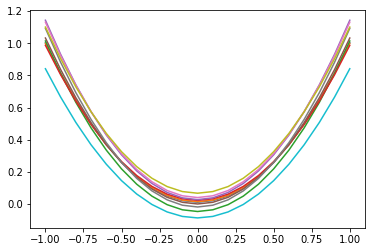

In [50]:
# Create some data 
x = np.linspace(-1, 1, 21)
y = poly10(x, model_set_axis=False)
for value in y:
    plt.plot(x, value)

<strong>We defined the fitter (linfitter) during the Chebyshev example

In [51]:
fitpoly = linfitter(poly10, x, y)
print("The fitting results for all 10 models:\n\n{}".format(fitpoly))

The fitting results for all 10 models:

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 10
Degree: 2
Parameters:
              c0                      c1                   c2        
    ---------------------- ----------------------- ------------------
      0.011246531607976265  1.1534784671430197e-16 0.9907032675216321
      0.014046425470686966                     0.0 0.9853521112690635
      -0.04665250328866317  1.1534784671430197e-16 1.0605427132265335
       0.02273918279727479  1.1534784671430197e-16 0.9641547033430485
       0.02712452507931276  2.3069569342860393e-16  1.115621124870582
    0.00020917928743628057  1.1534784671430197e-16 1.0319077495286162
      0.040116523063111656  1.1534784671430197e-16  1.090311671685765
     -0.018591330104657553  1.1534784671430197e-16 1.1109840589286035
       0.06704662664448532  2.3069569342860393e-16 1.0331919904012483
      -0.08653861068706806 -1.1534784671430197e-16 0.9277434431331503


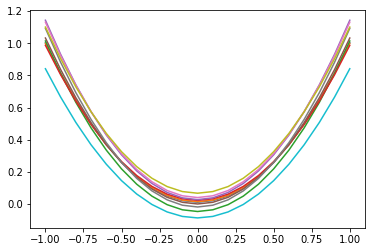

In [52]:
fitdata = fitpoly(x, model_set_axis=False)

for model in fitdata:
    plt.plot(x, model)

<hr>

## Exercise 2:


- read a spectrum from a text file (./sample_sdss.txt).
- Using the rest wavelengths as initial values, fit a gaussian to the H beta and OIII lines.

Use the rest wavelengths as initial values for the locations of the lines.
```
Hbeta = 4862.721
Halpha = 6564.614
OIII_1 = 4958.911
OIII_2 = 5008.239
Na = 6549.86
Nb = 6585.27
Sa = 6718.29
Sb = 6732.68
```

Text(0, 0.5, 'Flux')

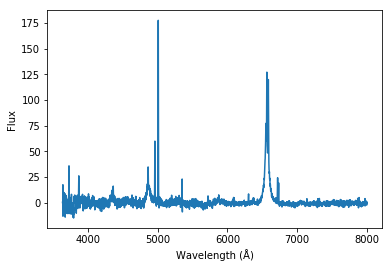

In [53]:
from astropy.io import ascii
sdss = ascii.read('./sample_sdss.txt')
#print(sdss.colnames)

# Plot to examine the data
wl = sdss['lambda']
flux = sdss['flux']
plt.plot(wl, flux)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")

Text(0, 0.5, 'Flux')

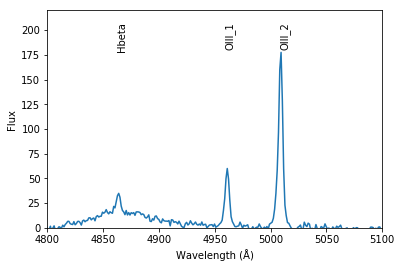

In [54]:
# Define the rest wavelengths of the lines
Hbeta = 4862.721
Halpha = 6564.614
OIII_1 = 4958.911
OIII_2 = 5008.239
Na = 6549.86
Nb = 6585.27
Sa = 6718.29
Sb = 6732.68

# make a plot with the lines of interest labeled
wl = sdss['lambda']
flux = sdss['flux']
plt.text(Hbeta, 200, 'Hbeta', rotation=90)
plt.text(OIII_1, 200, 'OIII_1', rotation=90)
plt.text(OIII_2, 200, 'OIII_2', rotation=90)
plt.plot(wl, flux)
plt.xlim(4800, 5100)
plt.ylim(0, 220)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")

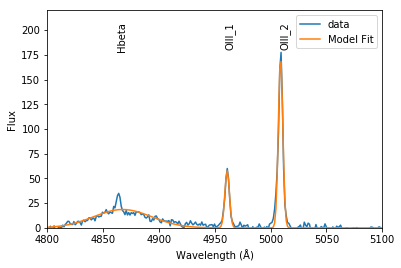

'Number of calls to function has reached maxfev = 100.'

In [55]:
# Fit Gaussians to the Hbeta and OIII lines
Hbeta_mdl = models.Gaussian1D(amplitude=25, mean=Hbeta, stddev=2)
OIII_1_mdl = models.Gaussian1D(amplitude=55, mean=OIII_1, stddev=2)
OIII_2_mdl = models.Gaussian1D(amplitude=175, mean=OIII_2, stddev=2)

# Create a composite model
comp_mdl = Hbeta_mdl + OIII_1_mdl +OIII_2_mdl

# Fit the model
model = fitter(comp_mdl, wl, flux)
#print(model)

# make a plot with the lines of interest labeled and the model fit
wl = sdss['lambda']
flux = sdss['flux']
plt.text(Hbeta, 200, 'Hbeta', rotation=90)
plt.text(OIII_1, 200, 'OIII_1', rotation=90)
plt.text(OIII_2, 200, 'OIII_2', rotation=90)
plt.plot(wl, flux, label="data")
plt.plot(wl, model(wl), label="Model Fit")
plt.legend()
plt.xlim(4800, 5100)
plt.ylim(0, 220)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.show()

# Warned about the fit possibly failing, so checking, look like maybe it hasn't converged yet?
fitter.fit_info['message']

# A better model would also fit the continuum with a polynomial

## <font color='blue'>Creating a transform chain that moves one set of values to another

<strong>The composition operator, |, combines models serially by chaining them one after the other. </strong>
<br><em>The number of outputs of a model must match the number of inputs of the next one.</em>
<br><br>

<strong>Let's use the previous example of the 2D Gaussian galaxy model that we created.
<br> We'll construct a new model that applies a 2D rotation of the input coordinates before calculating the gaussian model.</strong>

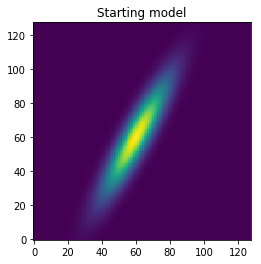

In [56]:
# remind ourselves what we had
x, y = np.mgrid[:128, :128]
plt.title("Starting model")
plt.imshow(gal_model(x,y), origin='lower')

In [57]:
# Set up the Rotation at a set angle of 23.1
rot = models.Rotation2D(angle=23.1, name='Rotation')

<strong>Create a new model that takes as input the (x, y) coordinates, rotates those, then sends them through the galaxy model.</strong>

In [58]:
rotate_galaxy = rot | gal_model
print(rotate_galaxy)

Model: CompoundModel4
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] | [1]
Components: 
    [0]: <Rotation2D(angle=23.1, name='Rotation')>

    [1]: <Gaussian2D(amplitude=0.0008, x_mean=60., y_mean=60., x_stddev=25., y_stddev=5., theta=0.5)>
Parameters:
    angle_0 amplitude_1 x_mean_1 y_mean_1 x_stddev_1 y_stddev_1 theta_1
    ------- ----------- -------- -------- ---------- ---------- -------
       23.1      0.0008     60.0     60.0       25.0        5.0     0.5


<strong>When you look at the information printed above for the compound model that we've created you can see that the new model:
<ul><li>Takes two input values
<li>Returns one output value
<li>Takes the information from the first model and "pipes" the output to the second (see Expression line)
<li>The first model applies the Rotation2D model with an angle of 23.1, and has been given the name 'Rotation'
<li>The second model applies the Gaussian2D model with the listed parameters
<li>The parameters for the entire compound model are summarized
</ul>
</strong>

<strong>The results:

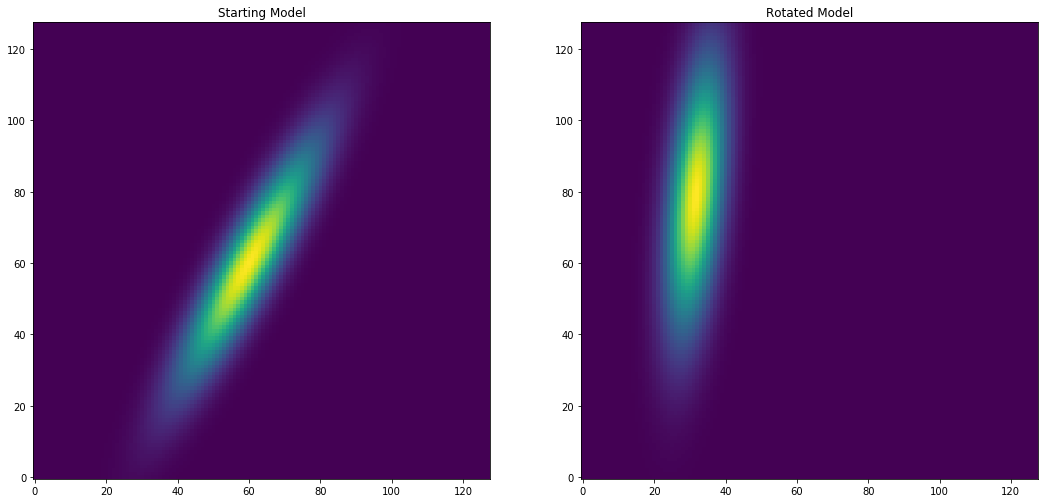

In [59]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,18))
ax1.set_title('Starting Model')
ax1.imshow(gal_model(x,y), origin='lower')
ax2.set_title('Rotated Model')
ax2.imshow(rotate_galaxy(x,y), origin='lower')

<strong>Chaining these two models as below is an error because the galaxy model has one output, while the rotation has two inputs.

In [60]:
broken_model = gal_model | rot 

ModelDefinitionError: Unsupported operands for |: None (n_inputs=2, n_outputs=1) and Rotation (n_inputs=2, n_outputs=2); n_outputs for the left-hand model must match n_inputs for the right-hand model.

<strong>The join operator, *&*, evaluates the child models on independent inputs and the results are concatenated.</strong>
<br>
The number of inputs passed to the combined model must equal the total number of inputs of all models.

<strong>Below, we are going to combine rotation with a shift of the y coordinate for the model, no shift is performed on the x coordinate</strong>

In [61]:
shift_rotate_galaxy = models.Shift(50) & models.Identity(1) | rot | gal_model

# Identity returns the model unchanged
# Shift shifts a coordinate (unclear why just the y-coordinate)

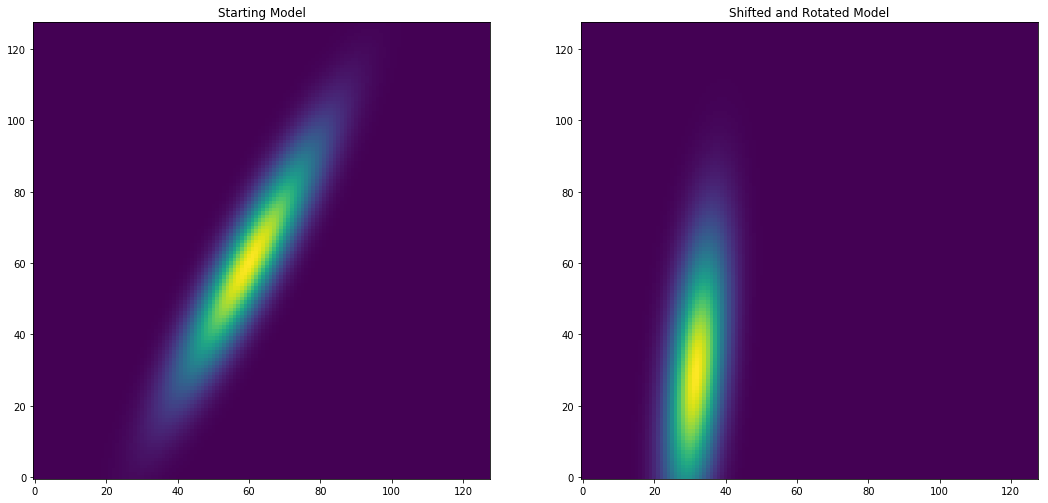

In [62]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,18))
ax1.set_title('Starting Model')
ax1.imshow(gal_model(x,y), origin='lower')
ax2.set_title('Shifted and Rotated Model')
ax2.imshow(shift_rotate_galaxy(x,y), origin='lower')

The **Mapping** model takes a tuple of indices into the inputs and returns the corresponding inputs. 
<br>It is useful for changing the order of inputs, dropping or adding inputs. 
<br><br>
We'll make yet another model that reverses the x and y coordinates going into the galaxy model.

In [63]:
# the values (1,0) instruct the chain to take the zeroth input value and swap it with the first
invert_galaxy = models.Mapping((1,0)) | gal_model

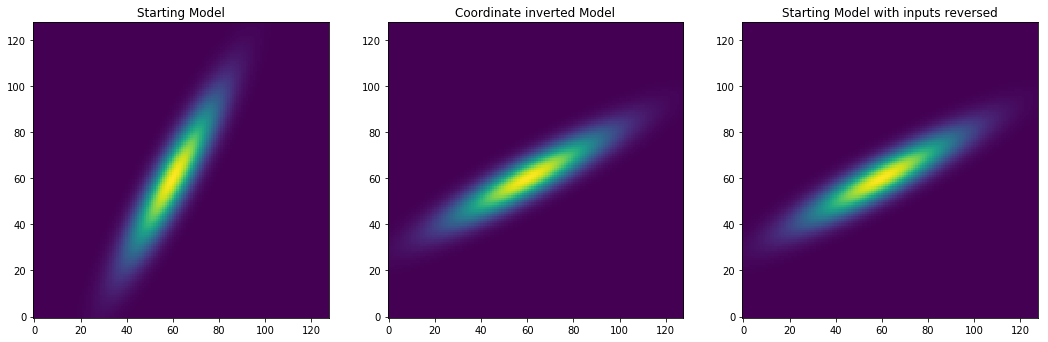

In [64]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,18))
ax1.set_title('Starting Model')
ax1.imshow(gal_model(x,y), origin='lower')

ax2.set_title('Coordinate inverted Model')
ax2.imshow(invert_galaxy(x,y), origin='lower')

ax3.set_title('Starting Model with inputs reversed')
ax3.imshow(gal_model(y,x), origin='lower')

## Inverse of a model

<strong>All models have a Model.inverse property which may, for some models, return a new model that is the analytic inverse of the model it is attached to. 
<br>It is also possible to assign a "custom_inverse" by assigning a model to the *inverse* attribute.</strong>

In [65]:
poly1 = models.Polynomial2D(degree=1, c0_0=2, c0_1=.1, c1_0=2, name='Poly_X')

<strong>This returns an error because an analytical inverse transform has not been implemented for polynomial models

In [66]:
print(poly1.inverse)

NotImplementedError: An analytical inverse transform has not been implemented for this model.

### Once you assign a transform it should work. You can do that by assiging a model as the inverse....

In [67]:
poly2 = models.Polynomial2D(degree=1, c0_0=1, c1_0=2, name='Poly_Y')
poly1.inverse = poly2
print(poly1.inverse)

Model: Polynomial2D
Name: Poly_Y
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
    c0_0 c1_0 c0_1
    ---- ---- ----
     1.0  2.0  0.0


### .... but you can also create a custom model...... 

<strong>Quite a few models are already defined in modeling. In order to see a list of the models, don't execute the following cell, instead place your cursor after the period and hit the "tab" key, this will bring up a list of models:

In [ ]:
models.

<strong>In most cases a new model can be easily defined following an existing model as an example.
<br>
However, there's also a decorator, which works with user defined functions and turns them onto models.

In [69]:
from astropy.modeling.models import custom_model

@custom_model
def sine_model(x, amplitude=1, frequency=1):
    return amplitude * np.sin(2 * np.pi * frequency * x)

model = sine_model(amplitude=3, frequency=2.1) # initialize the model
print(model(0.25))

-0.4693033951206923


<strong>To supply also a derivative, *custom_model* can be used as a function.

In [70]:
def sine_model(x, amplitude=1, frequency=1):
    return amplitude * np.sin(2 * np.pi * frequency * x)

def sine_deriv(x, amplitude=1, frequency=1):
    return 2 * np.pi * amplitude * np.cos(2 * np.pi * frequency *x)

SineModel = custom_model(sine_model, fit_deriv=sine_deriv) # create the class
model = SineModel(3, 2.1)# and initialize the model
print(model(0.25))

-0.4693033951206923
